Here, we explore how different deck styles can be expected to perform in Splinterlands. These simulations are greatly simplified compared to what is truly happening in the ranked ladder, but I want to demonstrate something that I think might be overlooked as a min-max strategy, and that is likely going to be much more common after Chaos Legion leaves the modern ladder.  

## Deck styles
We consider two types of decks: a full deck (has all cards at a given level - bronze, silver, gold, diamond), and a single-summoner deck (dual splinter, all cards playable by the chosen splinter)
##### The full deck
- Has all cards leveled to the limits for one of the old leagues. 
- Bronze/Silver/Gold/Diamond
##### The single-summoner deck
- Dual Splinter summoner
- Summoner leveled to the limit for one of the old leagues
- Has all cards playable the maximal level allowed for their summoner level. 

## Simulation strategy:
- 3000 players, all playing the same amount of games.
- 400 games per player - roughly all energy for a 14 day season plus some energy gained from chests.
- Each player is assigned a deck style and a deck level. Full decks can take deck levels 1-4 (bronze -> diamond), while the single-summoner decks are included only for deck levels 2-4 (silver-diamond).

# Python classes and functions needed for this simulation

In [2]:
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


class Decktype(Enum):
    FULL = 1
    SINGLE = 2


class Player:
    def __init__(self, deck_type=Decktype.FULL, deck_level=1, element=None):
        self.rating = 100
        self.deck_type = deck_type
        self.deck_level = deck_level
        self.element = element
        self.streak = 0
        self.matches = 0

    def check_elements(self, elements):
        if self.deck_type == Decktype.FULL:
            return True
        if len(np.intersect1d(self.element, elements)) > 0:
            return True
        return False

    def add_win(self):
        self.rating += 20
        self.streak += 1
        if self.streak >= 3 and self.rating < 3700:
            self.rating += 20

    def add_loss(self):
        self.rating = max(100, self.rating-20)
        self.streak = 0

Above we have defined an enumeration class to indicate the deck style, and a player class to hold a players deck info and their rating. The class has a function to check if for a single-summoner style deck, the battle elements allow the player to use their summoner or not. (This function is not relevant for the full decks). 

In [3]:
def resolve_battle(p1: Player, p2: Player, elements=np.ones(6)):
    level_diff = p1.deck_level - p2.deck_level
    diff_to_chance = {0: 0.5, 1: 0.90, 2: 0.99, 3: 0.999,
                      -1: 0.1, -2: 0.01, -3: 0.001}
    p1_el = p1.check_elements(elements)
    p2_el = p2.check_elements(elements)
    if (p1.deck_type == Decktype.SINGLE
            and p2.deck_type == Decktype.SINGLE):
        if p1_el and not p2_el:
            return 1
        elif p2_el and not p1_el:
            return 2
        elif not p1_el:  # None, random result
            return np.random.choice([1, 2], size=1)
        else:  # Both
            rng = np.random.random()
            if rng < diff_to_chance[level_diff]:
                return 1
            else:
                return 2
    elif (p1.deck_type == Decktype.FULL
          and p2.deck_type == Decktype.FULL):
        rng = np.random.random()
        if rng < diff_to_chance[level_diff]:
            return 1
        else:
            return 2
    elif p1.deck_type == Decktype.SINGLE:
        if not p1_el:
            return 2
        else:
            rng = np.random.random()
            if rng < diff_to_chance[level_diff]:
                return 1
            else:
                return 2
    else:
        if not p2_el:
            return 1
        else:
            rng = np.random.random()
            if rng < diff_to_chance[level_diff]:
                return 1
            else:
                return 2



We have a function to resolve a battle between decks. For same type, same level decks, I use a 50-50 chance for each player; I have not added different player skills. If one deck is higher level than the other, it has a much higher chance of winning. I assume a 90% win chance if there is one deck-level difference between the decks, 99% if there are two deck-levels difference and 99.9% if there is a 3 deck-level difference. The last one corresponds to a bronze deck versus a diamond deck - I think its reasonable to assume that the diamond deck only loses about 1/1000. of these matches. 

If there is a single-summoner deck involved in the battle, it will auto-lose if it cannot play its summoner. I check this by comparing the assigned player elements (which dual summoner it has) against the battle's allowed elements. If it can play its summoner, I assume it has 50-50 win chance against an equal level full deck (this is debatable. On one hand the full deck has more options, but on the other the single-summoner player will be an expert on playing that summoner). 

In [4]:
def find_match(p, players):
    for i in range(len(players)):
        p1 = players[i]
        rating_diff = abs(p.rating-p1.rating)
        if i < 200 and rating_diff < 200:
            return True, i
        elif i < 400 and rating_diff < 400:
            return True, i
        elif i < 600 and rating_diff < 600:
            return True, i
        elif i < 800 and rating_diff < 800:
            return True, i
        elif rating_diff <= 1000:
            return True, i
        elif p.rating >= 3700 and p1.rating >= 3700:
            return True, i
    return False, 0



We also have a function to find matchups. I don't know exactly how splinterlands does this, but I believe it expands the allowed rating difference over time in the queue. I have not made a battle-queue in the same sense, but I use index in my player list as a proxy for it. I don't believe that the matching strategy has a large impact here, except for limiting to +-1000 rating difference below Champ rating. 


## Setting up our players and running simulations
We use 3000 players. Most of them with bronze-level decks, and the succesively fewer at higher level decks. I looked at the ranks of the players in each league leaderboard (yes, we still have that available even if its not used below champ) to find out roughly how many players we have in the different rating levels.

I also assume that some fraction of all decks use single-summoner styles. To begin with, we can allow 20% of players to use this style. 

In [5]:

def initialize(Np=3000, fractions=[0.55, 0.25, 0.125, 0.075],
               single_probability=0.2):
    # Np: Players
    # fractions: Proportion in each deck level

    # Random numbers to set up player styles and deck levels
    rng1 = np.random.random(Np)
    rng2 = np.random.choice([1, 2, 3, 4], p=fractions, size=(Np))
    rng3 = np.random.choice(range(5), size=(Np, 2))

    # Initialize players
    players = []
    for i in range(Np):
        if rng1[i] < single_probability:
            p = Player(deck_type=Decktype.SINGLE, deck_level=max(2, rng2[i]),
                    element=rng3[i])
        else:
            p = Player(deck_type=Decktype.FULL, deck_level=rng2[i])
        players.append(p)
    return players


def simulate(players, matches=400):
    # Run simulation
    for _ in range(matches):
        np.random.shuffle(players)
        matched = []

        while len(players) > 0:
            p1 = players.pop(0)
            tf, j = find_match(p1, players)
            if tf:
                p2 = players.pop(j)
                elements = np.random.choice([0, 1], size=6)
                if elements[:5].sum() == 0:
                    elements[np.random.choice(5)] = 1
                res = resolve_battle(p1, p2, elements=np.where(elements)[0])
                if res == 1:
                    p1.add_win()
                    p2.add_loss()
                else:
                    p2.add_win()
                    p1.add_loss()
                matched.append(p1)
                matched.append(p2)
                p1.matches += 1
                p2.matches += 1
            else:
                matched.append(p1)
        players = matched
    return players

Finally, we have all we need to run the simulation. Lets initialize and start it:

In [6]:
players = initialize() # Just use the default parameters
players = simulate(players, matches=400)

Now we have the simulation results. Just have to do a little processing to show the results. 

Single Summoner, Silver average rating 1351.0
Single Summoner, Gold average rating 2436.0
Single Summoner, Diamond average rating 3290.0
Full deck, Bronze average rating 551.0
Full deck, Silver average rating 2019.0
Full deck, Gold average rating 3160.0
Full deck, Diamond average rating 4244.0


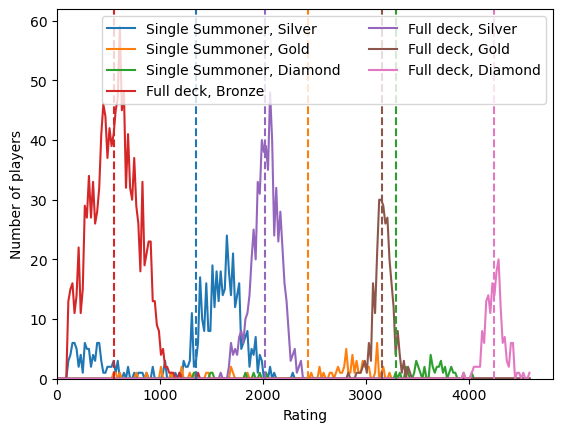

In [7]:

def get_ratings(players, deck_type, deck_level):
    return [x.rating for x in players if x.deck_type == deck_type
            and x.deck_level == deck_level]


def plot_results(players):

    ratings = [x.rating for x in players]
    single_ratings_l2 = get_ratings(players, Decktype.SINGLE, 2)
    single_ratings_l3 = get_ratings(players, Decktype.SINGLE, 3)
    single_ratings_l4 = get_ratings(players, Decktype.SINGLE, 4)
    full_ratings_l1 = get_ratings(players, Decktype.FULL, 1)
    full_ratings_l2 = get_ratings(players, Decktype.FULL, 2)
    full_ratings_l3 = get_ratings(players, Decktype.FULL, 3)
    full_ratings_l4 = get_ratings(players, Decktype.FULL, 4)
    max_rating = max(ratings)
    bins = np.arange(0, max_rating+40, 20)
    all = [single_ratings_l2,
        single_ratings_l3,
        single_ratings_l4,
        full_ratings_l1,
        full_ratings_l2,
        full_ratings_l3,
        full_ratings_l4]
    names = ["Single Summoner, Silver",
            "Single Summoner, Gold", 
            "Single Summoner, Diamond",
            "Full deck, Bronze",
            "Full deck, Silver",
            "Full deck, Gold",
            "Full deck, Diamond"]
    f, ax = plt.subplots(1, 1)
    for x in all:
        c, be = np.histogram(x, bins=bins)
        bc = be[:-1]+0.5*np.diff(be)
        l, = ax.plot(bc, c)
    for i, x in enumerate(all):
        ax.axvline(np.nanmean(x), color=f'C{i}', linestyle='dashed')
        print(names[i], ": Average rating", np.round(np.nanmean(x)))
    ax.legend(names, ncol=2)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.set_xlabel("Rating")
    ax.set_ylabel("Number of players")
    plt.show()

plot_results(players)

The plot shows the rating distribution of our players at the end of the simulation. The color of the lines indicate the deck style and level (as denoted in the plot legend). Along the horizontal axis we have the rating, and the vertical axis shows the number of players at that rating. The vertical dashed lines show the average rating of the deck-style and level. 

We can see that the four full deck styles have clustered into four separate groups (not surprising, since we did not include and skill separation of the players within these groups). The single-deck players are fewer in number, but what we can take note of is that the single-deck styles generally outperform, or at worst is similar in performance to the full decks at one deck-level lower.

To put it more simply. A single-summoner silver level deck is **stronger** than a full bronze deck. A single-summoner gold level deck is stronger than a full silver level deck, etc...

Single Summoner, Silver average rating 1304.0
Single Summoner, Gold average rating 2634.0
Single Summoner, Diamond average rating 3268.0
Full deck, Bronze average rating 589.0
Full deck, Silver average rating 1985.0
Full deck, Gold average rating 3137.0
Full deck, Diamond average rating 4229.0


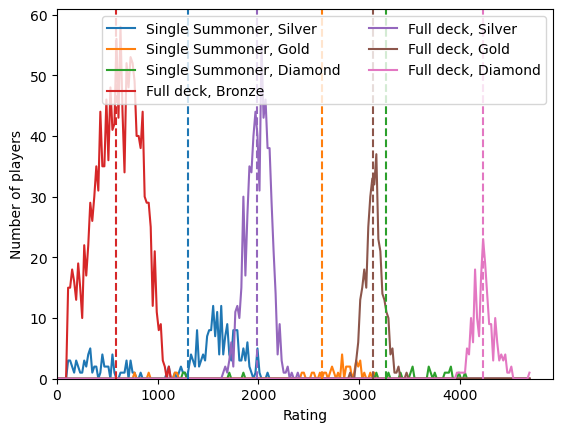

In [8]:
players = initialize(single_probability=0.1)
players = simulate(players)
plot_results(players)